<a href="https://colab.research.google.com/github/PrithaSarkar/Dissertation/blob/main/Pull_request_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing and importing necessary packages.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import sklearn

Mounting drive and loading the datafile. Change the location as applicable.

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Dissertation UofG 2022/new_pullreq.csv")

In [3]:
columns = df.columns.to_list()
print(columns)

['id', 'project_id', 'github_id', 'pull_request_id', 'ownername', 'reponame', 'merged_or_not', 'lifetime_minutes', 'mergetime_minutes', 'num_commits', 'src_churn', 'test_churn', 'files_added', 'files_deleted', 'files_modified', 'files_changed', 'src_files', 'doc_files', 'other_files', 'num_commit_comments', 'num_issue_comments', 'num_comments', 'num_participants', 'sloc', 'team_size', 'perc_external_contribs', 'commits_on_files_touched', 'test_lines_per_kloc', 'test_cases_per_kloc', 'asserts_per_kloc', 'watchers', 'prev_pullreqs', 'requester_succ_rate', 'followers', 'churn_addition', 'churn_deletion', 'pr_comment_num', 'comment_num', 'perc_neg_emotion', 'perc_pos_emotion', 'perc_neu_emotion', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'part_num_code', 'comment_conflict', 'hash_tag', 'at_tag', 'test_inclusion', 'description_length', 'bug_fix', 'ci_exists', 'ci_latency', 'ci_build_num', 'ci_test_passed', 'ci_failed_perc', 'ci_first_build_status', 'ci_last_build_status', 'languag

The "merged_or_not" metric states whether a pull-request was accepted or not. Let us check, how many of the 3 million pull-request was accepted and how many were rejected.

In [4]:
accepted = 0
rejected = 0
for ind in df.index:
  if df["merged_or_not"][ind]==1:
    accepted = accepted+1
  else:
    rejected = rejected+1

print("Accepted:", accepted)
print("Percentage:", (accepted/len(df))*100)
print("Rejected:", rejected)
print("Percentage:", (rejected/len(df))*100)

Accepted: 2710096
Percentage: 80.94823767591804
Rejected: 637841
Percentage: 19.051762324081963


There is a huge imbalance in the two classes. This needs to be kept in mind from this point onwards.

**Preparing data for small-scale experiment.**

The original dataset has 120 columns/metrics related to each pull-request. However, we will only focus on the metrics present in Table 1 of [this paper](https://dl.acm.org/doi/10.1145/3379597.3387489).

In [5]:
def flow_from_df(dataframe: pd.DataFrame, chunk_size: int = int(len(df)/3)):
  for start_row in range(0, dataframe.shape[0], chunk_size):
    end_row  = min(start_row + chunk_size, dataframe.shape[0])
    yield dataframe.iloc[start_row:end_row, :]

In [6]:
get_chunk = flow_from_df(df)
train_eval_test = next(get_chunk)
train_eval_test

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,353,51228565,Joaogarciadelima,checklistos,0,1410,NaN,1,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115974,1115975,5854,747,622191,mozilla,kitsune,0,28,NaN,1,...,0,1,0,0,170.0,0,0.016863,0,28,0
1115975,1115976,22043279,484,10320793,algolia,instantsearch.js,1,170,170.0,4,...,0,2,0,0,26.0,1,0.068429,0,170,0
1115976,1115977,26373298,3749,55041673,palantir,atlasdb,1,224,224.0,7,...,0,0,8,0,5068.0,1,0.000000,0,224,0
1115977,1115978,4952344,16732,61943628,spring-projects,spring-boot,0,2852,NaN,1,...,0,0,0,0,25.0,0,0.022494,0,2852,0


In [7]:
list_of_metrics = ['acc_commit_num', 'first_pr', 'core_member',
                  'contrib_gender', 'same_country', 'same_affiliation',
                  'social_strength', 'account_creation_days',
                  'first_response_time', 'contrib_country',
                  'prior_interaction', 'contrib_affiliation', 'perc_external_contribs',
                  'contrib_first_emo', 'contrib_follow_integrator',
                  'language', 'project_age', 'pushed_delta',
                  'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num',
                  'churn_addition', 'bug_fix', 'test_inclusion',
                  'hash_tag', 'at_tag', 'part_num_issue', 'part_num_commit',
                  'part_num_pr', 'part_num_code','ci_exists', 'ci_latency',
                  'ci_test_passed', 'ci_failed_perc', 'churn_deletion',
                  'description_length', 'comment_conflict', 'pr_comment_num',
                  'part_num_code', 'ci_build_num', 'perc_inte_neg_emo', 'perc_inte_pos_emo',
                  'perc_inte_neu_emo','ci_first_build_status', 'ci_last_build_status',
                   'merged_or_not']

for metric in columns:
  if metric not in list_of_metrics:
    train_eval_test.drop(metric, axis=1, inplace=True)

train_eval_test

,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
0,1,0.089869,0,0,0,1,0,0,0,0,...,NaN,NaN,0.0,0.000000,1.000000,0,28,0.000000,NaN,NaN
1,0,0.014019,0,0,0,1,0,0,0,0,...,NaN,NaN,0.0,0.000000,0.000000,0,300,0.250000,NaN,NaN
2,1,0.256849,0,0,0,0,0,0,0,0,...,NaN,NaN,0.0,0.000000,0.000000,0,505,0.428571,1.0,NaN
3,1,0.014706,110,3,0,0,0,0,0,0,...,NaN,NaN,0.0,0.000000,0.000000,1,460,0.138889,NaN,NaN
4,1,0.173077,60,0,0,1,0,0,0,0,...,NaN,NaN,0.0,1.000000,0.000000,1,6,0.125000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115974,0,0.059289,1,1,0,2,0,0,0,0,...,NaN,NaN,0.0,0.000000,0.000000,0,143,0.352941,NaN,NaN
1115975,1,0.009098,679,6,0,2,0,0,0,0,...,NaN,neutral,0.0,0.333333,0.666667,1,219,0.888889,NaN,NaN
1115976,1,0.042204,373,74,8,0,0,2,2,0,...,NaN,NaN,0.0,0.000000,1.000000,0,0,0.000000,NaN,NaN
1115977,0,0.157848,23,21,0,0,0,0,0,0,...,NaN,NaN,0.0,0.000000,0.000000,1,33,0.070175,NaN,NaN


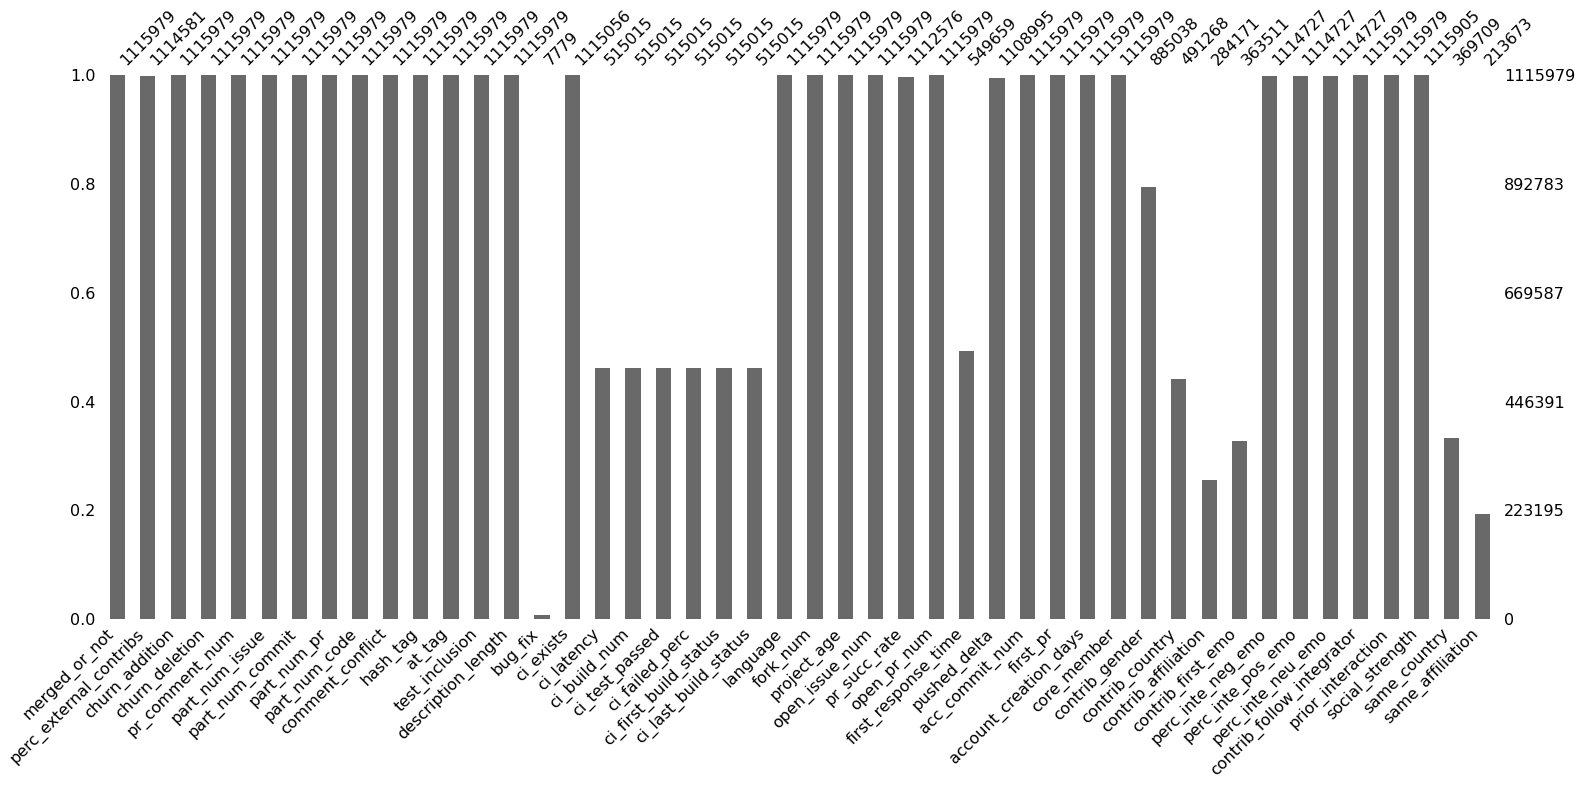

In [8]:
msno.bar(train_eval_test)

Even though there are a couple of metrics which have high number of null values, decision to keep them for now has been taken. Feature selection will be done when XGBoost will be deployed on the data. Subsequently, the most important features will be observed and the rest of them will be dropped from the experiment.

Let us now see the percentage of accepted and rejected pull-request in this data chunk and see if the class imbalance remains the same or has worsened.

In [9]:
accepted = 0
rejected = 0
for ind in train_eval_test.index:
  if train_eval_test["merged_or_not"][ind]==1:
    accepted = accepted+1
  else:
    rejected = rejected+1

print("Accepted:", accepted)
print("Percentage:", (accepted/len(train_eval_test))*100)
print("Rejected:", rejected)
print("Percentage:", (rejected/len(train_eval_test))*100)

Accepted: 903069
Percentage: 80.92168401018299
Rejected: 212910
Percentage: 19.078315989817014


Splitting the train_eval_test dataframe into separate training, evaluation and testing sets. 50% of the entire dataset will be used for training, 30% of the dataset will be used for evaluation/validation purposes and the remaining 20% will be used to run tests.

An important step before that would be to check the data types of every column since classification models would expect int, bool or float daat types. However, the dataset is diverse and annotation is required.

In [10]:
print(train_eval_test.dtypes)

merged_or_not                  int64
perc_external_contribs       float64
churn_addition                 int64
churn_deletion                 int64
pr_comment_num                 int64
part_num_issue                 int64
part_num_commit                int64
part_num_pr                    int64
part_num_code                  int64
comment_conflict               int64
hash_tag                       int64
at_tag                         int64
test_inclusion                 int64
description_length             int64
bug_fix                      float64
ci_exists                    float64
ci_latency                   float64
ci_build_num                 float64
ci_test_passed               float64
ci_failed_perc               float64
ci_first_build_status         object
ci_last_build_status          object
language                      object
fork_num                       int64
project_age                    int64
open_issue_num                 int64
pr_succ_rate                 float64
o

Metrics "ci_first_build_status", "ci_last_build_status", "language", "contrib_gender", contrib_country", "contrib_affiliation", "contrib_first_emo" have data type of object. This would cause trouble when deploying XGBoost. Annotation is needed in this case; manual or otherwise. Let's check the unique values present in each of these metrics.

In [11]:
object_metrics = ['ci_first_build_status', 'ci_last_build_status', 'language', 
                  'contrib_gender', 'contrib_country', 'contrib_affiliation', 'contrib_first_emo']

for metric in object_metrics:
  if metric == 'ci_first_build_status':
    ci_first_build_unique = train_eval_test[metric].unique()
    print(metric,':', ci_first_build_unique, ', #',len(ci_first_build_unique))
  if metric == 'ci_last_build_status':
    ci_last_build_unique = train_eval_test[metric].unique()
    print(metric,':', ci_last_build_unique, ', #',len(ci_last_build_unique))
  if metric == 'language':
    language_unique = train_eval_test[metric].unique()
    print(metric,':', language_unique, ', #',len(language_unique))
  if metric == 'contrib_gender':
    cotrib_gender_unique = train_eval_test[metric].unique()
    print(metric,':', cotrib_gender_unique, ', #',len(cotrib_gender_unique))
  if metric == 'contrib_country':
    cotrib_country_unique = train_eval_test[metric].unique()
    print(metric,':', cotrib_country_unique, ', #',len(cotrib_country_unique))
  if metric == 'contrib_affiliation':
    cotrib_affiliation_unique = train_eval_test[metric].unique()
    print(metric,':', cotrib_affiliation_unique, ', #',len(cotrib_affiliation_unique))
  if metric == 'contrib_first_emo':
    cotrib_first_emo_unique = train_eval_test[metric].unique()
    print(metric,':', cotrib_first_emo_unique, ', #',len(cotrib_first_emo_unique))   

ci_first_build_status : ['success' 'failure' nan] , # 3
ci_last_build_status : ['success' 'failure' nan] , # 3
language : ['JavaScript' 'Python' 'Go' 'Scala' 'Java' 'Ruby'] , # 6
contrib_gender : [nan 'male' 'female'] , # 3
contrib_country : [nan 'malaysia' 'canada' 'united states' 'peru' 'portugal' 'brazil'
 'austria' 'united kingdom' 'hungary' 'south africa' 'nepal' 'nicaragua'
 'russia' 'turkey' 'italy' 'china' 'iran' 'spain' 'czech republic'
 'germany' 'japan' 'nigeria' 'new zealand' 'pakistan' 'philippines'
 'australia' 'sri lanka' 'ukraine' 'switzerland' 'singapore' 'france'
 'belgium' 'chile' 'india' 'poland' 'taiwan' 'bangladesh' 'finland'
 'costa rica' 'netherlands' 'lithuania' 'greece' 'ireland' 'south korea'
 'norway' 'denmark' 'argentina' 'venezuela' 'belarus'
 'northern mariana islands' 'vietnam' 'luxembourg' 'lebanon' 'uzbekistan'
 'sweden' 'bulgaria' 'uganda' 'slovenia' 'croatia' 'united arab emirates'
 'estonia' 'israel' 'panama' 'indonesia' 'latvia' 'mexico' 'romania'


In [12]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
for metric in object_metrics:
  train_eval_test[metric] = le.fit_transform(train_eval_test[metric])

In [13]:
train = train_eval_test.sample(frac = 0.5)
train_eval_test.drop(train.index)
eval = train_eval_test.sample(frac = 0.3)
train_eval_test.drop(eval.index)
test = train_eval_test.sample(frac = 0.2)

In [14]:
len(train), len(eval), len(test)

(557990, 334794, 223196)

In [15]:
print(train.equals(eval))
print(eval.equals(test))
print(test.equals(train))

False
False
False


In [16]:
train.head(3)

,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
118870,1,0.077236,0,0,0,0,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,124,0.000000,1.0,NaN
1071971,1,0.081967,1,1,0,0,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,1,0.000000,NaN,NaN
969375,1,0.024885,100,1,0,0,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,72,0.015306,1.0,NaN


In [17]:
eval.head(3)

,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
185914,1,0.029412,31,2,0,2,0,0,0,0,...,1185,1,0.0,0.0,0.0,0,719,0.461538,NaN,NaN
179472,1,0.000000,0,0,0,0,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,637,0.250000,NaN,NaN
469305,1,0.040816,0,2,0,0,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,14,0.035714,NaN,NaN


In [18]:
test.head(3)

,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
304042,1,0.297597,34,8,0,2,0,0,0,0,...,1185,1,0.0,0.0,0.0,0,41,0.307692,1.0,NaN
70151,1,0.031250,52,29,0,0,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,52,0.000000,1.0,NaN
992518,1,0.557377,17,9,0,1,0,0,0,0,...,1185,1,0.0,0.0,0.0,0,402,0.194444,1.0,NaN


# ***XGBoost***

Run the following cell to install XGBoost. Skip otherwise.

In [19]:
#!pip3 install xgboost

In [20]:
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

In [21]:
X = train.iloc[:, 1:]
y = train["merged_or_not"]

In [22]:
model = XGBClassifier()

In [23]:
model.fit(X,y)

XGBClassifier()

It is time to test the model out. But before doing so, let's move the "merged_or_not" column from the test dataset and set it aside for comparison.

In [24]:
test_results = test['merged_or_not']

In [25]:
test.drop('merged_or_not', axis=1, inplace=True)

K-fold cross validation on XGBoost model. Setting some parameter values based off of educated guess.

In [26]:
from xgboost import cv

train_xgb = xgb.DMatrix(X, y)
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=train_xgb, params=params, nfold=3,
            num_boost_round=50, early_stopping_rounds=10, 
            metrics="auc", as_pandas=True, seed=123)

In [27]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.717053,0.000920,0.716267,0.001494
1,0.739265,0.003843,0.738511,0.002262
2,0.747218,0.004677,0.746334,0.004716
3,0.754286,0.006198,0.753411,0.005311
4,0.760991,0.007264,0.759632,0.008601


In [28]:
y_pred = model.predict(test)
print(y_pred)

print("Computation Time")
start=datetime.now()
print(datetime.now()-start)

[1 1 1 ... 1 1 1]
Computation Time
0:00:00.000063


In [29]:
results = (test_results == y_pred)
accuracy = results.sum() / results.size
print(accuracy)

0.8440070610584419


In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary(description, true_labels, predictions, target_classes):
  print("Evaluation for: " + description)
  target_names = target_classes
  report = classification_report(true_labels, predictions,  digits=3, zero_division=0, target_names=target_names)
  cm = confusion_matrix(true_labels, predictions)
  plt.figure(figsize=(12,12))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title("Confusion Matrix")
  ax.xaxis.set_ticklabels(target_names) 
  ax.yaxis.set_ticklabels(target_names)
  return report

Evaluation for: Baseline Model
              precision    recall  f1-score   support

    Accepted      0.751     0.277     0.405     42740
    Rejected      0.851     0.978     0.910    180456

    accuracy                          0.844    223196
   macro avg      0.801     0.628     0.658    223196
weighted avg      0.832     0.844     0.813    223196



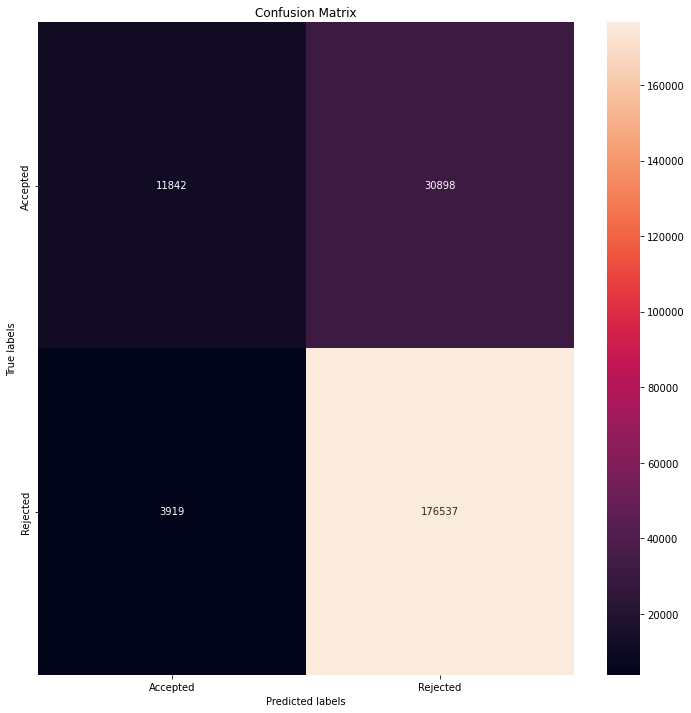

In [31]:
target_classes = ['Accepted', 'Rejected']
print(evaluation_summary("Baseline Model", test_results, y_pred , target_classes))

ROC-AUC curve code taken from [here](https://www.kaggle.com/code/beletecheneke/xgboost-with-roc-curve-notebook-auprc-93) 

In [32]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
def roc_auc_curve(test_results, y_pred):
  fpr, tpr, _ = roc_curve(test_results.values, y_pred)
  roc_auc = auc(fpr, tpr)
  #xgb.plot_importance(gbm)
  #plt.show()
  plt.figure(figsize=(5,5))
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([-0.02, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

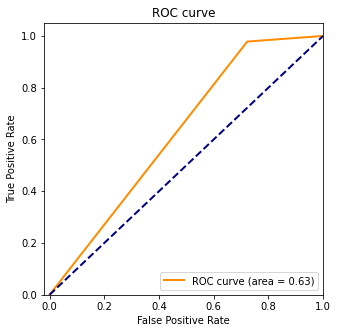

In [33]:
roc_auc_curve(test_results, y_pred)

### **Feature Selection with XGBoost and SHAP**

Study [this](https://notebook.community/minesh1291/MachineLearning/xgboost/feature_importance_v1) to understand how feature importance is decided in the following graph.

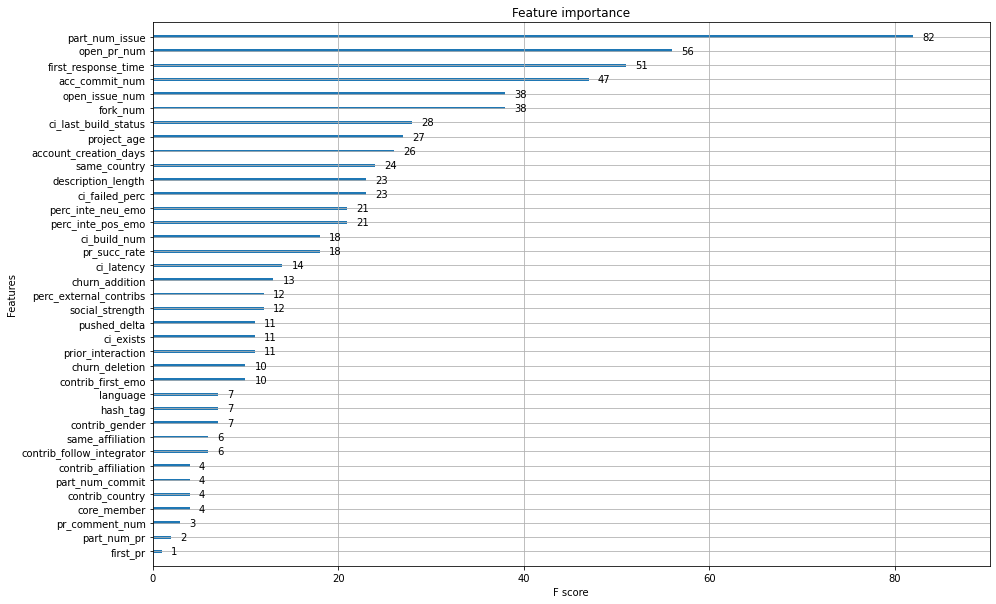

In [34]:
plt.rcParams["figure.figsize"] = (15, 10)
plot_importance(model)
plt.show()

In [35]:
!pip3 install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import shap

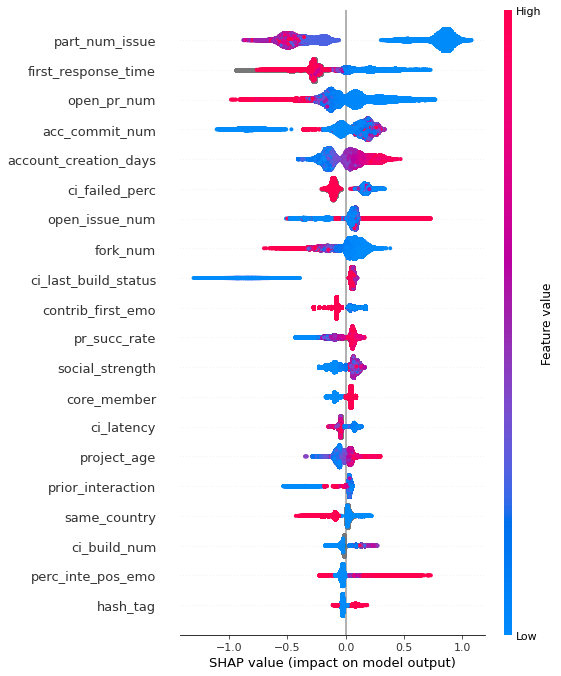

In [37]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)

shap.initjs()
shap.summary_plot(shap_values, test)

Understanding the Shapley Value [here](https://christophm.github.io/interpretable-ml-book/shapley.html). [More](https://arxiv.org/pdf/2102.10936.pdf) things about Shapley.

Get rid of features one by one!

Interpreting the SHAP plot:
1. The y-axis indicates importance of the metrics with the top-most one being the most important one and the bottom one being the least important metric.
2. The x-axis is the SHAP values, indiacting the change in log-odds.
3. Gradient color indicates the original value for that variable. 
4. Each point represents the row from the original dataset.

[Reference] [link text](https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/)

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [39]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
print(sorted_idx)
for index in sorted_idx:
  print([X.columns[index], model.feature_importances_[index]])

[32 36 41 29 42 18  4 20 27 31 15 14 26 25 24 22 23 33  1 12 38 16 43  2
 28 34  3  9 30 21  5 40 39  0  6 44 35 10 11  8  7 13 17 19 37]
['core_member', 0.11654197]
['contrib_first_emo', 0.10692883]
['prior_interaction', 0.081706524]
['acc_commit_num', 0.07037822]
['social_strength', 0.05619008]
['ci_failed_perc', 0.0434267]
['part_num_issue', 0.041046187]
['ci_last_build_status', 0.039002575]
['first_response_time', 0.034497175]
['account_creation_days', 0.031307098]
['ci_latency', 0.029758815]
['ci_exists', 0.028889881]
['open_pr_num', 0.02886672]
['pr_succ_rate', 0.02810469]
['open_issue_num', 0.025552355]
['fork_num', 0.023817934]
['project_age', 0.017440632]
['contrib_gender', 0.016928893]
['churn_addition', 0.01681233]
['description_length', 0.01587411]
['perc_inte_pos_emo', 0.015343183]
['ci_build_num', 0.013620404]
['same_country', 0.0116270175]
['churn_deletion', 0.010287016]
['pushed_delta', 0.010100828]
['contrib_country', 0.009765747]
['pr_comment_num', 0.0093344]
['hash_t

In [40]:
sum = 0.0
for value in model.feature_importances_:
  sum = sum+value

threshold_1 = sum/len(model.feature_importances_)
print(threshold_1)

0.022222223857210743


In [41]:
imp_features_1 = []
for index in sorted_idx:
  if threshold_1>=model.feature_importances_[index]:
    imp_features_1.append(X.columns[index])

print(imp_features_1)

['project_age', 'contrib_gender', 'churn_addition', 'description_length', 'perc_inte_pos_emo', 'ci_build_num', 'same_country', 'churn_deletion', 'pushed_delta', 'contrib_country', 'pr_comment_num', 'hash_tag', 'first_pr', 'language', 'part_num_commit', 'contrib_follow_integrator', 'perc_inte_neu_emo', 'perc_external_contribs', 'part_num_pr', 'same_affiliation', 'contrib_affiliation', 'at_tag', 'test_inclusion', 'comment_conflict', 'part_num_code', 'bug_fix', 'ci_test_passed', 'ci_first_build_status', 'perc_inte_neg_emo']


In [42]:
X_new_1 = pd.DataFrame(columns = imp_features_1)
for feature in imp_features_1:
  X_new_1[feature] = train[feature]

model_new = XGBClassifier()

model_new.fit(X_new_1, y)

test_new_1 = pd.DataFrame(columns = imp_features_1)
for feature in imp_features_1:
  test_new_1[feature] = test[feature]

y_pred_new_1 = model_new.predict(test_new_1)

print("Computation Time")
start=datetime.now()
print(datetime.now()-start)

Computation Time
0:00:00.000072


In [43]:
results_new_1 = (test_results == y_pred_new_1)
accuracy_new_1 = results_new_1.sum() / results_new_1.size
print(accuracy_new_1)

0.816013727844585


Evaluation for: New Model with better performing features
              precision    recall  f1-score   support

    Accepted      0.702     0.068     0.124     42740
    Rejected      0.818     0.993     0.897    180456

    accuracy                          0.816    223196
   macro avg      0.760     0.531     0.511    223196
weighted avg      0.796     0.816     0.749    223196



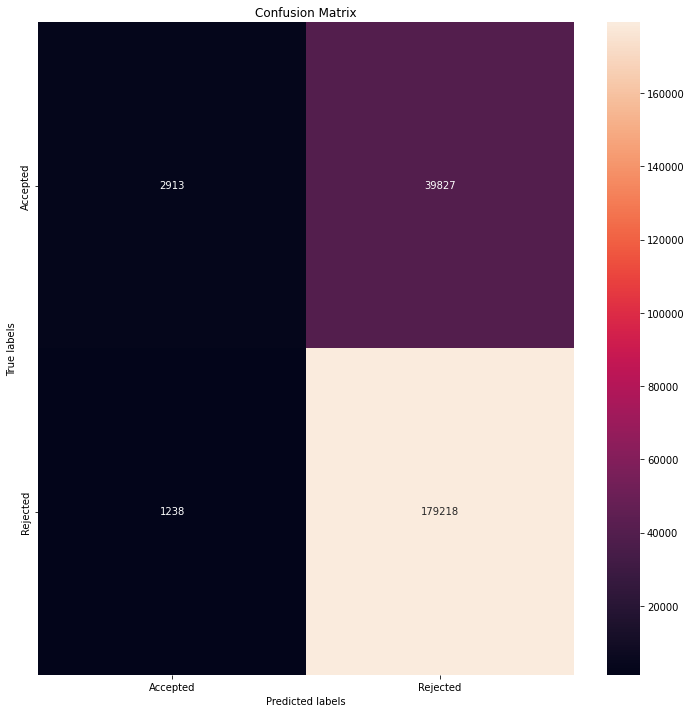

In [44]:
print(evaluation_summary("New Model with better performing features", test_results, y_pred_new_1 , target_classes))

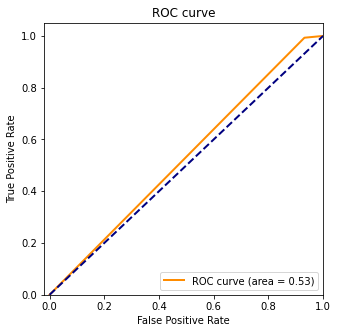

In [45]:
roc_auc_curve(test_results, y_pred_new_1)

Read [this](https://ai.stanford.edu/blog/removing-spuriousfeature/).
[Deciding the threshold for feature importance.](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00472-4)

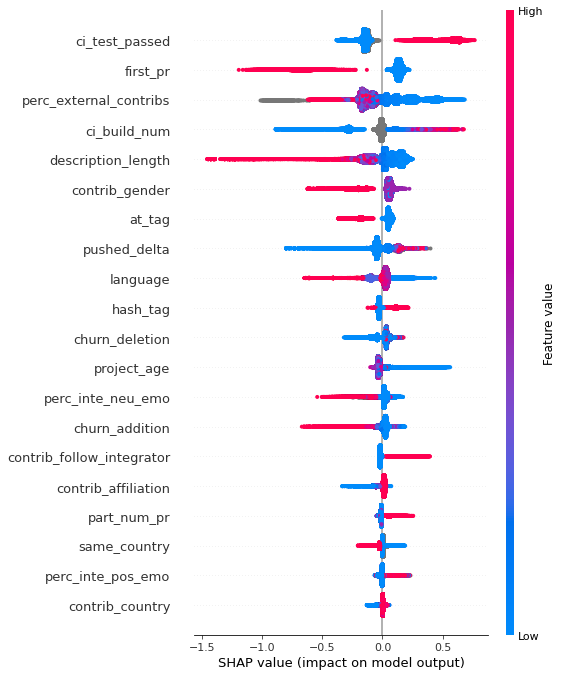

In [46]:
explainer_new_1 = shap.TreeExplainer(model_new)
shap_values_new_1 = explainer_new_1.shap_values(test_new_1)

shap.initjs()
shap.summary_plot(shap_values_new_1, test_new_1)

In [60]:
from numpy import diff

dx = threshold_1
threshold_2 = diff(model.feature_importances_)/dx
print(threshold_2)

imp_features_2 = []
for index in sorted_idx:
  for val in threshold_2:
    if val>=model.feature_importances_[index]:
      feature_to_consider = X.columns[index]
  imp_features_2.append(feature_to_consider)

print(imp_features_2)

[ 0.5020248  -0.29363912 -0.04286769  1.4270302  -1.463412   -0.15167488
 -0.23199135  0.          0.41170248 -0.41170248  0.          0.7143349
 -0.7143349   1.3000445   0.03910199 -0.7262285  -0.6129181   1.9542013
 -1.9542013   1.7551156  -1.3652848   0.681976   -0.28697857  0.3650275
  0.11485511  0.03429129  0.2533705  -1.0978355   2.7124825  -2.7603722
  1.0021718   3.8355684  -4.482588   -0.3223415  -0.3481884   4.7205267
 -4.811797    0.69044316 -0.38817286  0.06402303  3.3105     -1.1482399
 -2.0053375  -0.35317913]
['core_member', 'contrib_first_emo', 'prior_interaction', 'acc_commit_num', 'social_strength', 'ci_failed_perc', 'part_num_issue', 'ci_last_build_status', 'first_response_time', 'account_creation_days', 'ci_latency', 'ci_exists', 'open_pr_num', 'pr_succ_rate', 'open_issue_num', 'fork_num', 'project_age', 'contrib_gender', 'churn_addition', 'description_length', 'perc_inte_pos_emo', 'ci_build_num', 'same_country', 'churn_deletion', 'pushed_delta', 'contrib_country',

In [57]:
len(imp_features_2)

45

In [52]:
X_new_2 = pd.DataFrame(columns = imp_features_2)
for feature in imp_features_2:
  X_new_2[feature] = train[feature]

model_new.fit(X_new_2, y)

test_new_2 = pd.DataFrame(columns = imp_features_2)
for feature in imp_features_2:
  test_new_2[feature] = test[feature]

y_pred_new_2 = model_new.predict(test_new_2)

print("Computation Time")
start=datetime.now()
print(datetime.now()-start)

Computation Time
0:00:00.000075


In [53]:
results_new_2 = (test_results == y_pred_new_2)
accuracy_new_2 = results_new_2.sum() / results_new_2.size
print(accuracy_new_2)

0.8440070610584419


Evaluation for: New Model with better performing features
              precision    recall  f1-score   support

    Accepted      0.751     0.277     0.405     42740
    Rejected      0.851     0.978     0.910    180456

    accuracy                          0.844    223196
   macro avg      0.801     0.628     0.658    223196
weighted avg      0.832     0.844     0.813    223196



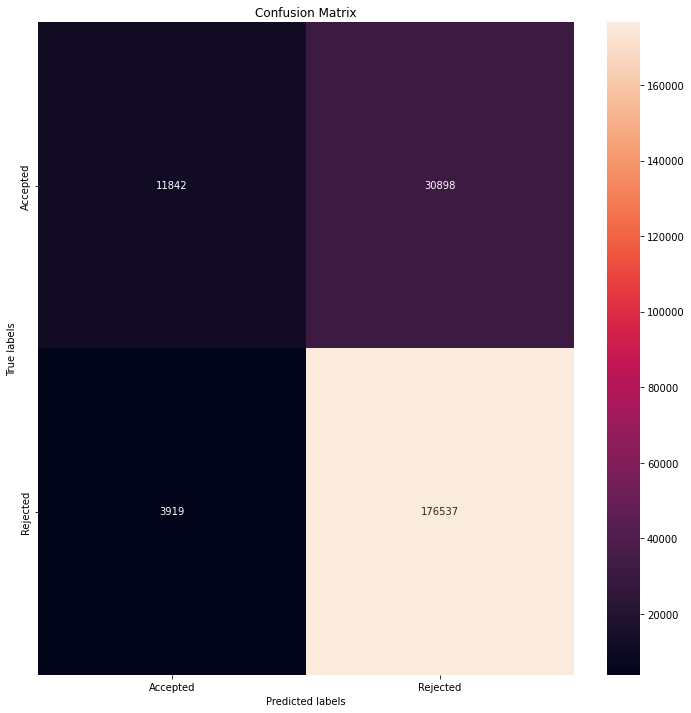

In [54]:
print(evaluation_summary("New Model with better performing features", test_results, y_pred_new_2 , target_classes))

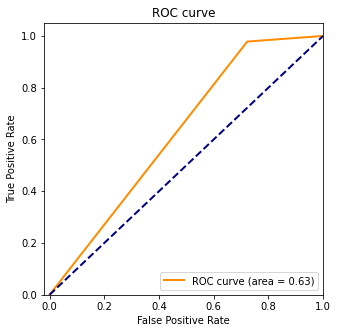

In [55]:
roc_auc_curve(test_results, y_pred_new_2)

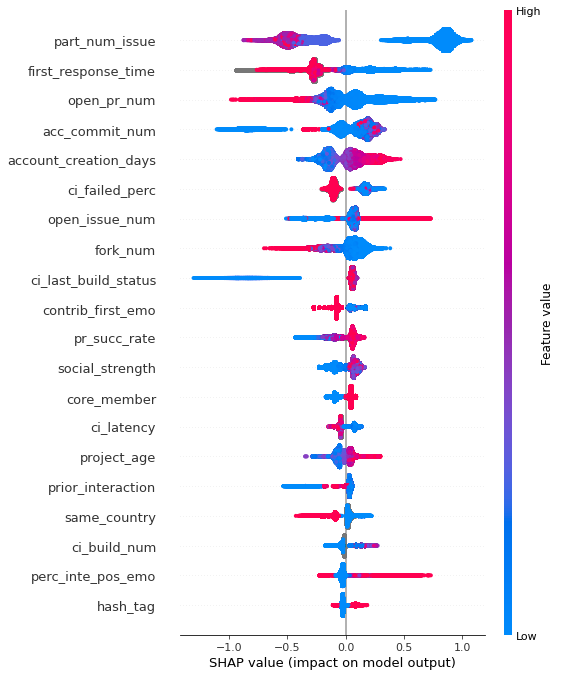

In [56]:
explainer_new_2 = shap.TreeExplainer(model_new)
shap_values_new_2 = explainer_new_2.shap_values(test_new_2)

shap.initjs()
shap.summary_plot(shap_values_new_2, test_new_2)

**Parameter Tuning**

In [ ]:
"""
from sklearn.model_selection import GridSearchCV

def model_pipeline(X, test, y, y_pred, model, param_grid, cv, 
                   scoring_fit='neg_mean_squared_error', do_probabilities = False):
  
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X, y)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(test)
    else:
      pred = fitted_model.predict(test)
    
    return fitted_model, pred
    """

In [ ]:
"""
param_grid = {
    'learning_rate': [0.3, 0.5, 0.8],
    'max_depth': [2, 6],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

model, pred = model_pipeline(X, test, y, y_pred, model, param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)
"""

1. Check [this](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/) out.
2. Check [this](https://www.kaggle.com/general/237792) out.
3. Check [this](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance/notebook) out for more XGBoost information.

Check [this](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) out for parameter tuning.

Click [here](https://www.kaggle.com/code/bryanb/xgboost-explainability-with-shap/notebook), [here](https://gmd.copernicus.org/preprints/gmd-2020-59/gmd-2020-59.pdf), [here](https://stackoverflow.com/questions/69937376/explaination-of-shap-value-from-xgboost) for more SHAP related documents.

For BEAM, look at actionable features and come up with why you can recommend something before the recommendation.

# **BEAM**
Study [this](https://www.width.ai/post/what-is-beam-search)

In [ ]:
pull_request_characteristics = ['churn_addition', 'bug_fix', 'test_inclusion',
                                'at_tag', 'part_num_X', 'ci_exists', 'ci_latency',
                                'ci_test_passed', 'ci_failed_perc', 'churn_deletion',
                                'description_length', 'comment_conflict', 'pr_comment_num',
                                'part_num_code', 'ci_build_num', 'perc_neg_emotion',
                                'perc_pos_emotion', 'perc_neu_emotion', 'ci_first_build_status',
                                'ci_last_build_status']

for feature in imp_features:
  if feature in pull_request_characteristics:
    print(feature," can be used for recommendation.")

In [ ]:
y_pred_new

In [ ]:
rejected_pull_request = np.where(y_pred_new == 0)

In [ ]:
rejected_pull_request = np.array(rejected_pull_request).tolist()

rpr = []
for l in rejected_pull_request:
    for val in l:
        rpr.append(val)

print(rpr)
print(len(rpr))

In [ ]:
'''
SESSION CRASHING
reco = pd.DataFrame(columns = test_new.columns)
for i in range(0, len(test_new)):
  if i in rpr:
    reco = reco.append(test_new[:i], ignore_index = True)
'''